# Ravelin Data Science Test
## Fraudulent detection
### source: https://github.com/unravelin/code-test-data-science 

### packages import

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_text

## The data

Provided data set is in json format. It contains profiles of customers from fictional ecommerce company. The profiles contain information about the customer, their order, their transaction, what peyments methods they used and whether the customer is fraudulent or not.

# 1. Reading the data
our data will be stored in 4 DataFrames: 
- customers (basic info about customer), 
- orders (all orders with attached customer id)
- payments (all payments methods attached to each customer account)
- transactions

In [3]:
data = pd.read_json('./customers.txt', lines=True)

customers = pd.DataFrame()
orders = pd.DataFrame()
payments = pd.DataFrame()
transactions = pd.DataFrame()

for i, row in data.iterrows():
    c = pd.DataFrame.from_dict([row.customer])
    c['fraudulent'] = row.fraudulent
    c['id'] = i
    customers = customers.append(c, ignore_index=True)
    
    o = pd.DataFrame.from_records(row.orders)
    o['id'] = i
    orders = orders.append(o, ignore_index=True, sort=True)
    
    p = pd.DataFrame.from_records(row.paymentMethods)
    p['id'] = i
    payments = payments.append(p, ignore_index=True, sort=True)
    
    t = pd.DataFrame.from_records(row.transactions)
    t['id'] = i
    transactions = transactions.append(t, ignore_index=True, sort=True)

## samples of the data

In [4]:
customers.sample(3)

,customerBillingAddress,customerDevice,customerEmail,customerIPAddress,customerPhone,fraudulent,id
41,1862 Melanie Islands Apt. 152\nNorth Williamha...,czrv4aped9e2ndgv89b5,smithtiffany@davis-perkins.com,141.224.72.49,384.291.0196x66623,False,41
132,USNS Ramos\nFPO AE 16248,jy8lgca2hto8r58zw5oo,cindydeleon@yahoo.com,2ebe:381c:151a:9df5:65f5:808f:103d:d128,01524024300,False,132
128,9205 Jeremiah Field Suite 815\nEast Christophe...,1djsf7mffce2xhvsf139,brianthomas@yahoo.com,219.222.4.152,04061905118,False,128


In [5]:
orders.sample(3)

,id,orderAmount,orderId,orderShippingAddress,orderState
86,28,42.0,any2ki,129 Sandra Meadows Suite 923\nEast Jenniferpor...,pending
420,151,45.0,1ca3sy,"12350 Nicholas Greens\nLawsonborough, NC 70237...",fulfilled
38,12,45.0,bdzhkd,"67636 Renee Islands Suite 307\nTeresaview, ND ...",pending


In [6]:
payments.sample(3)

,id,paymentMethodId,paymentMethodIssuer,paymentMethodProvider,paymentMethodRegistrationFailure,paymentMethodType
110,63,l1qil6tjh,Bastion Banks,American Express,False,card
141,74,p6v42gsjt,Grand Credit Corporation,VISA 16 digit,False,card
260,123,n1ehjoa66,Rose Bancshares,JCB 15 digit,False,card


In [7]:
transactions.sample(3)

,id,orderId,paymentMethodId,transactionAmount,transactionFailed,transactionId
469,131,5m0otl,bdsvwrzwf,33.0,False,6dwhx2bc
499,141,hnt2yf,xrqpqnjba,17.0,False,d4oenk4o
483,136,dzj9zm,5tyvyueom,45.0,False,d27dmlyt


# 2. Features preparation

#### DataFrame to store features

In [8]:
df = customers[['id', 'fraudulent']].copy()
df.set_index('id', inplace=True)

## Table 'customers'

#### Shape

In [9]:
customers.shape

(168, 7)

#### Empty records

In [10]:
customers[customers.isna().any(axis=1)]

,customerBillingAddress,customerDevice,customerEmail,customerIPAddress,customerPhone,fraudulent,id


#### Unique column values

In [11]:
customers.nunique()

customerBillingAddress    166
customerDevice            168
customerEmail             161
customerIPAddress         165
customerPhone             168
fraudulent                  2
id                        168
dtype: int64

### Observation: there are users with the same billing, email or IP address as others

In [12]:
emails = pd.DataFrame(customers.customerEmail.str.split('@').tolist(), columns=["username", "domain"])

df['u_duplicated_billingAddress'] = customers.customerBillingAddress.duplicated().astype(int)
df['u_duplicated_ip'] = customers.customerIPAddress.duplicated().astype(int)

# let's check if username is unique, not the whole email address
# because emails with the same username from different domains are suspect
# e.g: johnsmith@gmail.com | johnsmith@hotmail.com | johnsmith@yahoo.com
df['u_duplicated_email_username'] = emails.username.duplicated().astype(int)
# also lets check how many users use the same domain -  less frequent domains can indicate suspect accounts
df['u_customers_under_domain'] = emails.groupby('domain')['domain'].transform('size')

### Observation: some emila addresses are invalid (domain without dot, e.g: "9es7t@u6n7x 	")

In [13]:
df['u_email_valid'] = customers.customerEmail.str.contains('[^@]+@[^@]+\.[^@]+').astype(int)

## Table 'orders'

#### Table shape

In [14]:
orders.shape

(478, 5)

#### Empty records

In [15]:
orders[orders.isna().any(axis=1)]

,id,orderAmount,orderId,orderShippingAddress,orderState


#### Unique column values

In [16]:
orders.nunique()

id                      141
orderAmount              67
orderId                 478
orderShippingAddress    274
orderState                3
dtype: int64

### Observation: not all customers make order

In [17]:
m_orders = pd.merge(customers, orders, on='id', how='left')

In [18]:
# basic data about customer orders
df['o_total_orders'] = m_orders.groupby('id')['orderId'].count()
df['o_total_amount'] = m_orders.groupby('id')['orderAmount'].sum()
df['o_avg_amount'] = m_orders.groupby('id')['orderAmount'].mean().fillna(0)

### Observation: there are 3 states of order

In [19]:
df[['o_failed', 'o_fulfilled', 'o_pending']] = \
    m_orders.groupby('id')['orderState'].value_counts(dropna=False)\
    .unstack(fill_value=0)[['failed', 'fulfilled', 'pending']]

### Observation: there are more unique shipping adresses that customers

#### in this step we will check whether: <br> - shipping address is the same as billing<br> - shipping adress is the same as other customer billing address <br> - there is the same shipping address for two (or more) different customers

In [20]:
diff_address = m_orders[m_orders.customerBillingAddress != m_orders.orderShippingAddress]
uniqe_adresses = m_orders[['id', 'orderShippingAddress']].drop_duplicates().dropna()

# shipping address is not the same as billing
df['adr_diff_billing_shipping'] = 0
df.loc[df.index.isin(diff_address.id), 'adr_diff_billing_shipping'] = 1

# shipping address is the same as other customer billing address
df['adr_shipping_match_else_billing'] = 0
df.loc[df.index.isin(diff_address[diff_address.orderShippingAddress.isin(m_orders.customerBillingAddress)].id), 'adr_shipping_match_else_billing'] = 1

# shipping address occurs as shipping address of another customer
df['adr_shipping_math_else_shipping'] = 0
df.loc[df.index.isin(uniqe_adresses[uniqe_adresses.orderShippingAddress.duplicated()].id), 'adr_shipping_math_else_shipping'] = 1

#### Histogram of orders' amount

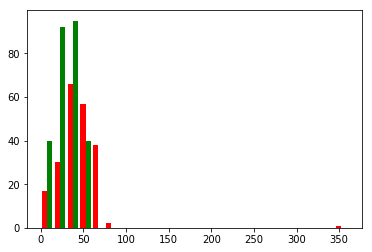

In [21]:
step = 15
plt.hist([m_orders[m_orders.fraudulent].orderAmount, 
          m_orders[~m_orders.fraudulent].orderAmount], 
         color=['r','g'], 
         bins=range(0, int(m_orders.orderAmount.max())+step, step))
plt.show()

### Observation: there is a suspect oderd which amount much greather that other orders (>350)

In [22]:
df['o_enormous_amount'] = (m_orders.groupby('id')['orderAmount'].max() > m_orders.orderAmount.quantile(0.999)).astype(int)

### let's groupy order by value to assign to bins

In [23]:
bins = [0, 20, 40, 50, 60, 80, 100]
temp = m_orders.groupby(['id', pd.cut(m_orders.orderAmount, 
                                      bins=bins, 
                                      labels=["o_amount_bin{}".format(i) for i in bins[1:]])]
                       ).size().unstack()
df = df.merge(temp, left_index=True, right_index=True).fillna(0)

## Table paymentMethod

#### Table shape

In [24]:
payments.shape

(342, 6)

#### Empty records

In [25]:
payments[payments.isna().any(axis=1)]

,id,paymentMethodId,paymentMethodIssuer,paymentMethodProvider,paymentMethodRegistrationFailure,paymentMethodType


#### Unique column values

In [26]:
payments.nunique()

id                                  156
paymentMethodId                     342
paymentMethodIssuer                  20
paymentMethodProvider                10
paymentMethodRegistrationFailure      2
paymentMethodType                     4
dtype: int64

#### Values in colum 'Issuer', 'Provider' and 'Type'

In [27]:
for col in ['paymentMethodIssuer', 'paymentMethodProvider', 'paymentMethodType']:
    print(col, ":", payments[col].unique(), "\n")

paymentMethodIssuer : ['Citizens First Banks' 'Solace Banks' 'Vertex Bancorp'
 'His Majesty Bank Corp.' 'Bastion Banks' 'Her Majesty Trust'
 'Fountain Financial Inc.' 'Grand Credit Corporation' 'B' 'p' 'x' 'e'
 'Bulwark Trust Corp.' 'c' 'a' 'Rose Bancshares' ' ' 'r' 'n' 'o'] 

paymentMethodProvider : ['JCB 16 digit' 'VISA 16 digit' 'Diners Club / Carte Blanche' 'Mastercard'
 'American Express' 'Maestro' 'Discover' 'Voyager' 'VISA 13 digit'
 'JCB 15 digit'] 

paymentMethodType : ['card' 'bitcoin' 'apple pay' 'paypal'] 



In [28]:
m_payments = pd.merge(customers, payments, on='id', how='left')

### Observation: customers have assigned many payment methods. There are 4 types, 10 providers and 20 issuers. Some Issuers seems suspect - thier names are single characters

In [29]:
df['p_total_methods'] = m_payments.groupby('id')['paymentMethodId'].count()

df = df.merge(
    m_payments.groupby('id')['paymentMethodType'].value_counts(dropna=False)\
        .unstack(fill_value=0)\
        .reset_index()\
        .add_prefix('p_method_')\
        .iloc[:,2:],
    how='left', left_index=True, right_index=True)

df['p_number_registration_failures'] = m_payments.groupby('id')['paymentMethodRegistrationFailure'].sum().astype(int)
df['p_unique_issuers'] = m_payments.groupby('id')['paymentMethodIssuer'].nunique()
df['p_unique_providers'] = m_payments.groupby('id')['paymentMethodProvider'].nunique()

df['p_all_issuers_valid'] = m_payments.groupby('id')['paymentMethodIssuer'].apply(lambda x: x.str.len().min() != 1).astype(int)

### Table 'transactions'

#### Table shape

In [30]:
transactions.shape

(623, 6)

#### Empty records

In [31]:
transactions[transactions.isna().any(axis=1)]

,id,orderId,paymentMethodId,transactionAmount,transactionFailed,transactionId


In [32]:
transactions.nunique()

id                   141
orderId              478
paymentMethodId      237
transactionAmount     67
transactionFailed      2
transactionId        623
dtype: int64

### Observation: not all customers have at least one transaction, all orders have at least one transaction

In [33]:
m_trans = pd.merge(customers, transactions, how='left', on='id')

### Basic stats

In [34]:
df['t_total_transactions'] = m_trans.groupby('id')['transactionId'].count()
df[['t_total_passed', 't_total_failed']] = m_trans.groupby('id')['transactionFailed'].value_counts(dropna=False).unstack(fill_value=0).iloc[:,-2:]
df[['t_amount_passed', 't_amount_failed']] = m_trans.fillna(0).groupby(['id', 'transactionFailed'])['transactionAmount'].sum().unstack(fill_value=0).iloc[:,-2:]

### Let's add feature - number of transaction with amount different  that order amount. Such difference clearly indicate fraud

In [35]:
df['t_diff_trans_order_amount'] = pd.merge(transactions[['id','transactionAmount', 'orderId']], orders[['id', 'orderId', 'orderAmount']], how='outer').groupby('id').apply(lambda x: (x.transactionAmount!=x.orderAmount).sum())
df['t_diff_trans_order_amount'].fillna(0, inplace=True)

### Orders with all transactions were rejected shoudn't have "fulfilled" state.

In [36]:
s = ~transactions.groupby('orderId')['transactionFailed'].all().astype(bool)
unpaid_orders = s[s == False].index


df['t_unpaid_orders'] = m_orders[m_orders.orderId.isin(unpaid_orders)].groupby('id')['orderId'].count()
df['t_unpaid_orders'].fillna(0, inplace=True)

df['t_unpaid_fulfilled_orders'] = m_orders[m_orders.orderId.isin(unpaid_orders) & (m_orders.orderState=='fulfilled')].groupby('id')['orderId'].count()
df['t_unpaid_fulfilled_orders'].fillna(0, inplace=True)

## Description of all features

 - **`u_duplicated_billingAddress`** - indicates whether the billing address is the same as another customer's
 - **`u_duplicated_ip`** - indicates whether IP address is the same as another customer's
 - **`u_duplicated_email_username`** - indicates whether username of email address (before @) is the same as another customer's
 - **`u_customers_under_domain`** - how many customers use the same domain in the email address
 - **`u_email_valid`** - indicates whether the email address is correct (domain without a dot)
 - **`o_total_orders`** - number of all orders for each customer
 - **`o_total_amount`** - total amount of all orders for each customer
 - **`o_avg_amount`** - average value of customer orders
 - **`o_failed`** - number of failed orders for each customer
 - **`o_fulfilled`** - number of completed orders for each customer
 - **`o_pending`** - number of pending orders 
 - **`adr_diff_billing_shipping`** - indicates whether customer has ever chosen shipping address different than billing address
 - **`adr_shipping_match_else_billing`** - indicates whether customer has ever chosen shipping address the same as another customer's billing address
 - **`adr_shipping_math_else_shipping`** - indicates whether customer has ever chosen shipping address as another customer
 - **`o_enormous_amount`** - indicates whether customer make order with value above 999-th percentile
 - **`o_amount_bin20`** - number of orders below amount: 20
 - **`o_amount_bin40`** - number of orders below amount: 40
 - **`o_amount_bin50`** - number of orders below amount: 50
 - **`o_amount_bin60`** - number of orders below amount: 60
 - **`o_amount_bin80`** - number of orders below amount: 80
 - **`p_total_methods`** - number of payment methods assigned to the customer
 - **`p_method_apple pay`** - how many payment methods are 'apple pay'
 - **`p_method_bitcoin`** -  how many payment methods are 'bitcoin'
 - **`p_method_card`** -  how many payment methods are credit card
 - **`p_method_paypal`** -  how many payment methods are 'paypal'
 - **`p_number_registration_failures`** - how many times there was an error for registering payment method for the customer
 - **`p_unique_issuers`** - number of unique issuers of customer payment methods
 - **`p_unique_providers`** - number of unique providers of customer payment methods
 - **`p_all_issuers_valid`** - indicates whether the customer has assigned payment method with invalid issuer (single-character name)
 - **`t_total_transactions`** - number of all transactions
 - **`t_total_passed`** - number of passed transactions
 - **`t_total_failed`** - number of failed transactions
 - **`t_amount_passed`** - total value of passed transactions
 - **`t_amount_failed`** - total value of failed transactions
 - **`t_diff_trans_order_amount`** - nubmer of transactions with different value than order value
 - **`t_unpaid_orders`** - number of orders for which all transactions failed
 - **`t_unpaid_fulfilled_orders`** - number of order for which all transaction failed but order is fulfilled

# 3. The model

In [37]:
rand_state = 1723

y = df.values[:, 0].tolist()
X = df.values[:, 1:].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=rand_state)

In [38]:
rfc = RandomForestClassifier(max_depth=30, n_estimators=1000, random_state=rand_state)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=1723,
                       verbose=0, warm_start=False)

### Model mean accuracy (test data)

In [39]:
rfc.score(X_test, y_test)

0.9523809523809523

### Confusion matrix

In [40]:
tn, fp, fn, tp = \
(confusion_matrix(y_test, rfc.predict(X_test))/len(y_test)).ravel()

print("true negative: {:.2%}\ntrue positive: {:.2%}\nfalse negative: {:.2%}\nfalse positive: {:.2%}\n".format(tn, tp, fn, fp))

print("sensitivity: {:.2%}".format(tp/(tp+fn)))
print("miss rate: {:.2%}".format(fn/(fn+tp)))

true negative: 57.14%
true positive: 38.10%
false negative: 4.76%
false positive: 0.00%

sensitivity: 88.89%
miss rate: 11.11%


# Visualisation

## Features contribution / importance

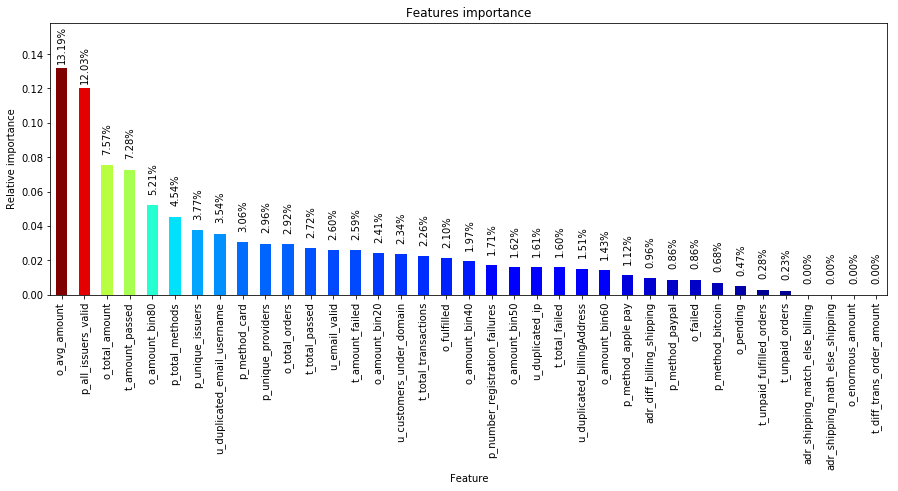

In [41]:
importance = pd.Series(rfc.feature_importances_, index=df.columns[1:]).sort_values(ascending=False)

ax = importance.plot(figsize=(15, 5), 
                     kind='bar', 
                     color=cm.get_cmap('jet')
                         (Normalize(vmin=importance.min(), vmax=importance.max())
                         (importance.values)),
                     ylim=(0, importance.max()*1.2)
                     )
for l in range(importance.size):
    ax.text(l-0.2, importance.iloc[l]+0.02, "{:.2%}".format(importance.iloc[l]), rotation=90)

plt.title('Features importance')
plt.xlabel('Feature')
plt.ylabel('Relative importance')
plt.show()

## Single sample decision tree

Due to the required additional software (graphviz) to visualize the tree in graphic form, it was decided to have a textual representation

In [42]:
tree_str = export_text(rfc.estimators_[rand_state%rfc.n_estimators], feature_names=list(df.columns[1:]))
print(tree_str)

|--- o_total_orders <= 5.50
|   |--- p_method_bitcoin <= 1.50
|   |   |--- p_all_issuers_valid <= 0.50
|   |   |   |--- class: 1.0
|   |   |--- p_all_issuers_valid >  0.50
|   |   |   |--- o_avg_amount <= 45.50
|   |   |   |   |--- o_failed <= 1.50
|   |   |   |   |   |--- u_duplicated_billingAddress <= 0.50
|   |   |   |   |   |   |--- o_total_amount <= 19.50
|   |   |   |   |   |   |   |--- p_total_methods <= 2.00
|   |   |   |   |   |   |   |   |--- t_amount_failed <= 8.00
|   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |--- t_amount_failed >  8.00
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- p_total_methods >  2.00
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- o_total_amount >  19.50
|   |   |   |   |   |   |   |--- u_duplicated_email_username <= 0.50
|   |   |   |   |   |   |   |   |--- o_avg_amount <= 37.88
|   |   |   |   |   |   |   |   |   |--- o_amount_bin40 <= 0.50
|   